In [1]:
import os
import shutil
import pathlib

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# **Data Understanding**


Memahami dataset yang digunakan, jumlah gambar, dan distribusi data


In [2]:
PATH = 'Data/garbage_classification'
PATH

'Data/garbage_classification'

In [3]:
# Determine the path directory for the data
data_dir = pathlib.Path(PATH)

# Count the number of images in the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

# Display the distribution of images in each label
print(f'\nDistribution Image')

for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    # Check if label_dir is a directory
    if os.path.isdir(label_dir):
        len_label_dir = len(os.listdir(label_dir))
        print(f'{i+1}. {label} : {len_label_dir}')

Total image from this datasets : 15515

Distribution Image
1. paper : 1050
3. green-glass : 629
4. clothes : 5325
5. metal : 769
6. cardboard : 891
7. trash : 697
8. biological : 985
9. white-glass : 775
10. battery : 945
11. brown-glass : 607
12. plastic : 865
13. shoes : 1977


# **Data Preparation**


Mempersiapkan data untuk pelatihan model, termasuk pembagian data menjadi training, validation, dan test set. Juga dilakukan augementasi data untuk meningkatkan performa model.


In [4]:
# Parameter batch size dan ukuran gambar
BATCH_SIZE = 32

IMG_SIZE = (224, 224)



np.random.seed(123)

seed = np.random.randint(0, 100)

print(f"Current seed : {seed}")

Current seed : 66


In [5]:
# Membagi data menjadi training dan validation set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)


val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [6]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

List label Validation data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


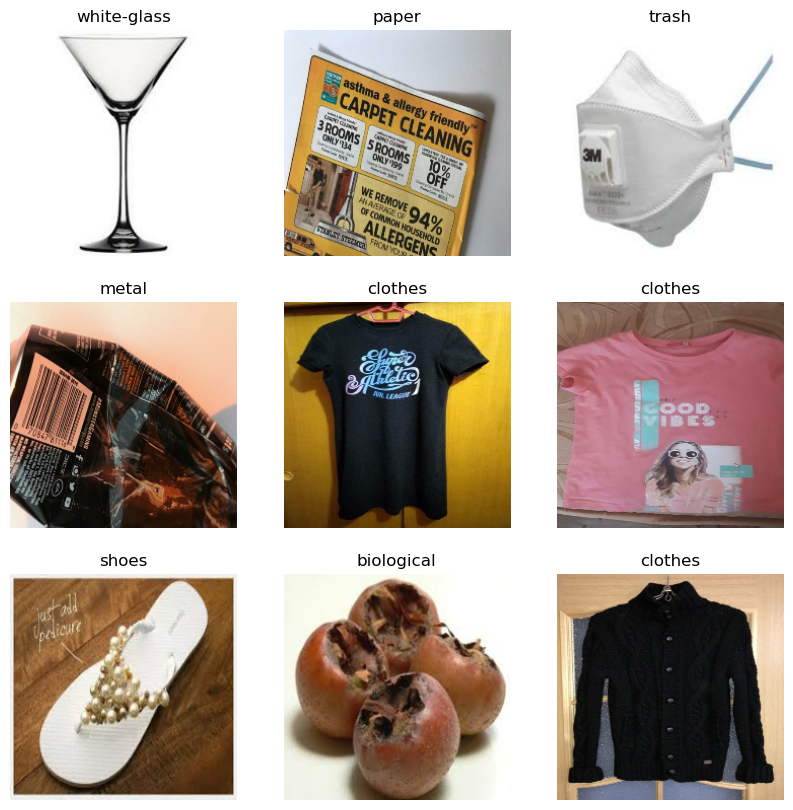

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
# Membagi validation set menjadi validation dan test set
val_batches = tf.data.experimental.cardinality(val_ds)

test_dataset = val_ds.take(val_batches // 5)

val_ds = val_ds.skip(val_batches // 5)


print('Number of validation batches: %d' %
      tf.data.experimental.cardinality(val_ds))

print('Number of test batches: %d' %
      tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 78
Number of test batches: 19


In [10]:
# Mengatur prefetching untuk performa optimal
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Modeling**


Membangun dan melatih model menggunakan arsitektur MobileNetV2 yang telah dilatih sebelumnya (pre-trained model). Model dilengkapi dengan lapisan augmentasi data dan normalisasi.


In [11]:
# Augmentasi data untuk meningkatkan performa model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)],
    name="data_augmentation")


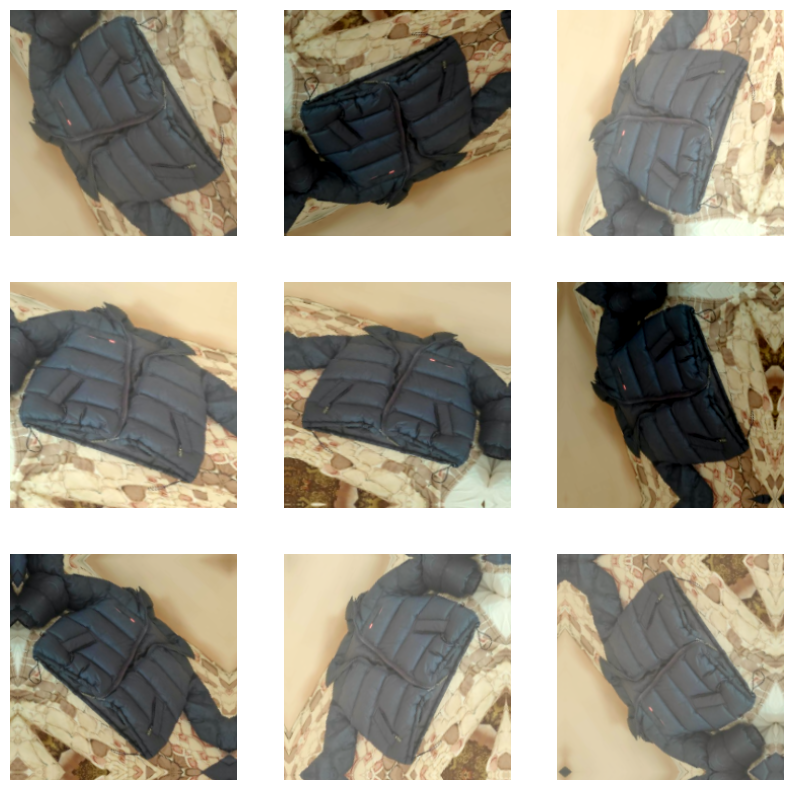

In [12]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [13]:
def model_builder():
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.Rescaling(1./255),

        # First Conv Block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SIZE + (3,)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Second Conv Block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Third Conv Block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    base_learning_rate = 1e-3
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model


In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10,
                                                  mode="max",
                                                  verbose=2,
                                                  restore_best_weights=True)

In [15]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.src.engine.sequential.Sequential object at 0x3217d2a70>


In [16]:
# Melatih model dengan callback untuk early stopping dan model checkpoint
history = model.fit(train_ds,
                    epochs=55,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/55
388/388 [==============================] - ETA: 0s - loss: 1.6016 - accuracy: 0.4615
Epoch 1: val_accuracy improved from -inf to 0.56794, saving model to checkpoint_model.h5
388/388 [==============================] - 189s 484ms/step - loss: 1.6016 - accuracy: 0.4615 - val_loss: 1.2565 - val_accuracy: 0.5679
Epoch 2/55
388/388 [==============================] - ETA: 0s - loss: 1.3182 - accuracy: 0.5537
Epoch 2: val_accuracy improved from 0.56794 to 0.60601, saving model to checkpoint_model.h5
388/388 [==============================] - 195s 503ms/step - loss: 1.3182 - accuracy: 0.5537 - val_loss: 1.1577 - val_accuracy: 0.6060
Epoch 3/55
388/388 [==============================] - ETA: 0s - loss: 1.2188 - accuracy: 0.5867
Epoch 3: val_accuracy improved from 0.60601 to 0.63447, saving model to checkpoint_model.h5
388/388 [==============================] - 211s 542ms/step - loss: 1.2188 - accuracy: 0.5867 - val_loss: 1.0974 - val_accuracy: 0.6345
Epoch 4/55
388/388 [==============

# **Evaluation**


Evaluasi model dilakukan dengan membandingkan akurasi pada data training dan validation, serta menggunakan data test set untuk evaluasi akhir.

In [36]:
%matplotlib inline
plt.style.use('seaborn')

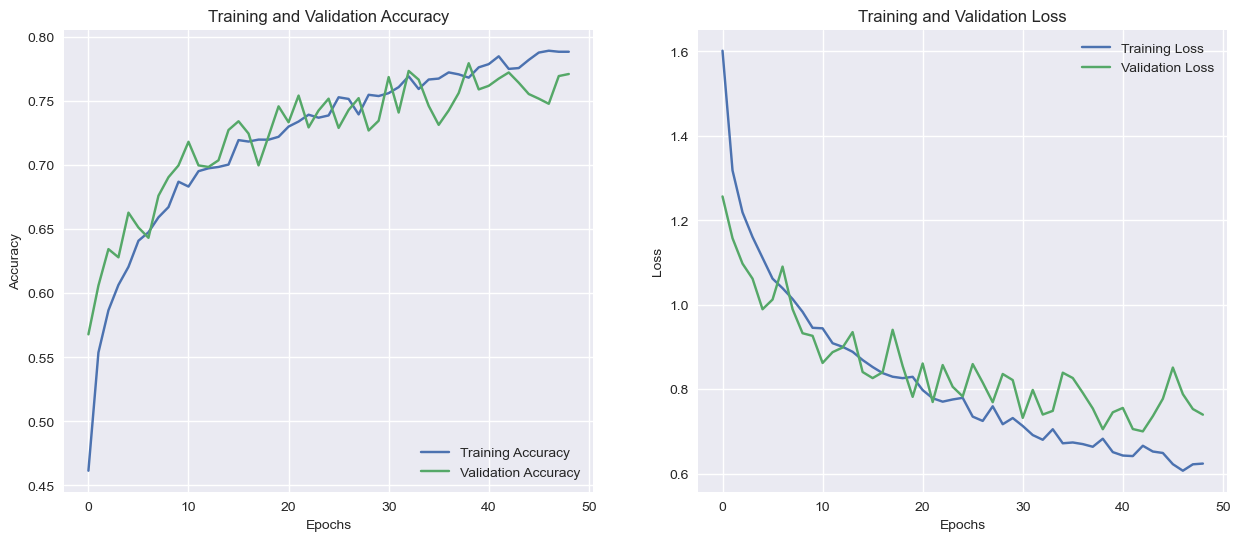

In [37]:
# Plotting akurasi dan loss untuk training dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [38]:
# Evaluasi model dengan data test set
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

19/19 [==============================] - 2s 112ms/step - loss: 0.7615 - accuracy: 0.7566


{'loss': 0.7615195512771606, 'accuracy': 0.7565789222717285}

In [39]:
class_names = np.array(class_names)
class_names_val = np.array(class_names_val)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']

List label Validation data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


In [40]:
image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 149ms/step
['clothes' 'shoes' 'shoes' 'biological' 'battery' 'plastic' 'trash'
 'clothes' 'clothes' 'clothes' 'battery' 'clothes' 'metal' 'metal'
 'clothes' 'paper' 'plastic' 'shoes' 'clothes' 'biological' 'battery'
 'paper' 'paper' 'clothes' 'paper' 'plastic' 'shoes' 'clothes'
 'white-glass' 'paper' 'battery' 'trash']


In [41]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
    if i in label_batch_test:
        true_predict += 1
    else:
        false_predict += 1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[ 7  9  9  1  6  8 10  4  4  4  0  4  6  3  4 11  8  2  4  1  0  7  7  4
  7  3  0  4 11  7  0 10]
Predicted labels:
[ 4  9  9  1  0  8 10  4  4  4  0  4  6  6  4  7  8  9  4  1  0  7  7  4
  7  8  9  4 11  7  0 10]

True Predict Count : 32
False Predict Count : 0


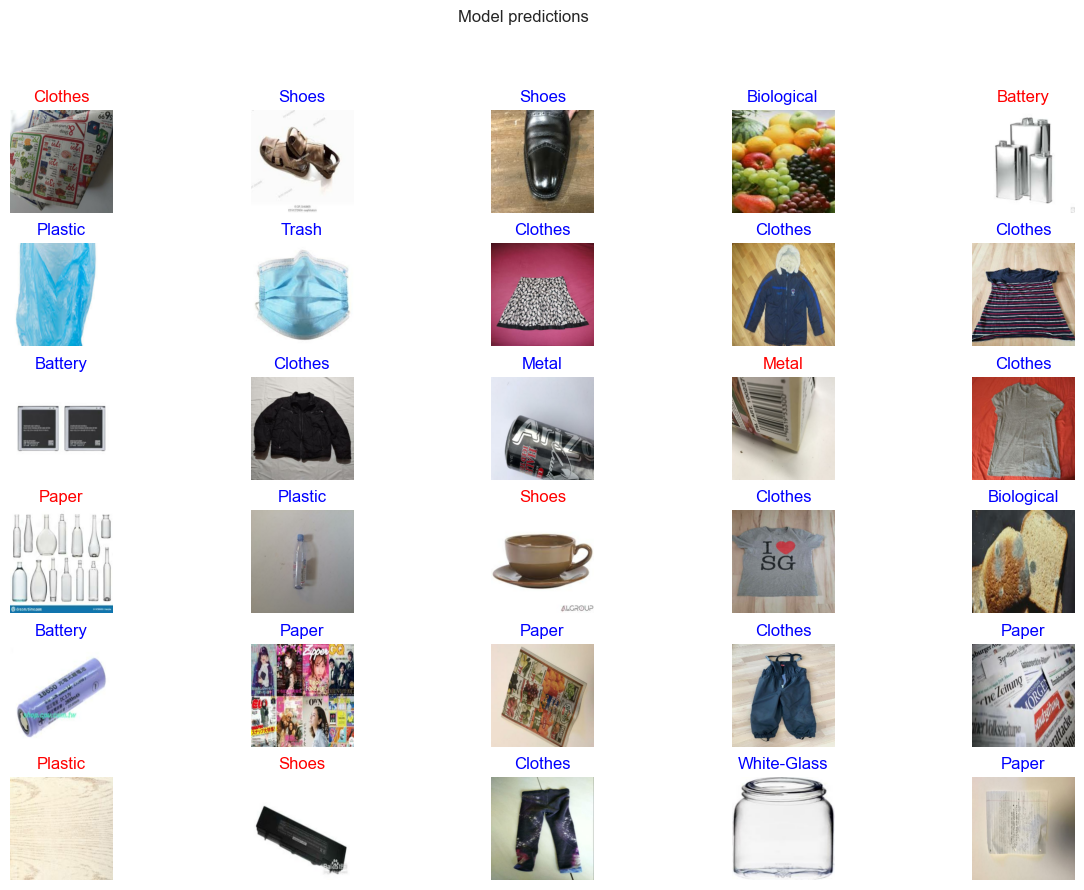

In [42]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch_test[n].astype('uint8'))
    color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions")

In [43]:
x_test = []
y_test = []

for x_batch, y_batch in test_dataset:
    for x_i, y_i in zip(x_batch, y_batch):
        x_test.append(x_i)
        y_test.append(y_i)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [44]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(x_test), axis=-1)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 2s 107ms/step
Accuracy: 75.49%


In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        32
           1       0.81      0.77      0.79        39
           2       0.93      0.67      0.78        21
           3       0.75      0.81      0.78        37
           4       0.85      0.95      0.89       201
           5       0.82      0.88      0.85        26
           6       0.48      0.38      0.42        29
           7       0.73      0.82      0.77        44
           8       0.66      0.51      0.58        37
           9       0.59      0.59      0.59        76
          10       0.71      0.62      0.67        24
          11       0.72      0.62      0.67        42

    accuracy                           0.75       608
   macro avg       0.73      0.69      0.70       608
weighted avg       0.75      0.75      0.75       608



In [46]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0

# **Deplyoment**

In [28]:
path_model = 'saved'
output_path = 'output_path'
load_model.save(path_model)

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [29]:
path_model = pathlib.Path(path_model)

## Konversi ke JSON agar dapat digunakan oleh frontend kita:)

In [47]:
!pip3 install --upgrade pip

In [48]:
!python -m venv tfjs-env
!source tfjs-env/bin/activate  # On Windows, use `tfjs-env\Scripts\activate`

In [49]:
!pip3 install tensorflowjs

In [50]:
!tensorflowjs_converter --version


tensorflowjs 4.20.0

Dependency versions:
  keras 2.15.1
  tensorflow 2.15.0


In [51]:
# !tensorflowjs_converter --input_format=tf_saved_model \
#                          --output_node_names='MobilenetV3/Predictions/Reshape_1' \
#                          --saved_model_tags=serve \
#                          './saved' \
#                          output_path

In [65]:
!tensorflowjs_converter --input_format=keras /checkpoint_model.h5 /tfjs_model

Traceback (most recent call last):
  File "/Users/cyukis/anaconda3/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/Users/cyukis/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/Users/cyukis/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 963, in main
    convert(argv[0].split(' '))
  File "/Users/cyukis/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 949, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/Users/cyukis/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 619, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/Users/cyukis/anaconda3/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 78, in dispatch_keras_h5_to_tfjs_layers_model_conversio